1. Introduction
==

Human tastes in music are remarkably diverse, therefore music recommender is a best tool to help people find what they like. Moreover, more precisely music recommender recommend means more money music company can earn. So that it is a huge attraction for music company to improve their music recommender. However, the usual method collaborative filtering (CF) techniques suffer from a cold-start problem in many of the less popular items.
Therefore, in order to increase the quality of recommender, we decide to implement a rich model for both the item and user biases, which accounts for the item taxonomy, user rating sessions. Besides, we expand basic personalization model to encompass more patterns observed in the data.

2. Related Work
==

There are several approaches to music recommendations:

1) Collaborative Filtering (CF) methods utilize user feedback (explicit or implicit) to infer relations in users and items, and ultimately relate users to items they like. This approach do not use domain knowledge.
Context Based Filtering methods characterize items based on textual attributes, cultural information, social tags and other kinds of web-based annotations. 

2) Given the nature of our dataset, we focus on a CF approach. However, algorithms based on basic collaborative filtering typically suffer from the cold-start problem when encountering items with little rating information. In our system [1], we use a taxonomy to share information between rated item, thus the representation of tracks with a little rating data naturally collapses to the representation of their respective album and artist which can lead to a better performance.

We would first employ a Matrix Factorization (MF) model which can be found at [2]. Typically, a predicted rating by user u to item i given by $r_{ui}=μ+b_i+b_u+p_u^Tq_i$ where $p_u^Tq_i$ captures the affinity of user $u$ to item $i$. Then, according to the base paper [1], we would enhance our bias model by letting item biases share components for items linked by the taxonomy and adding Items temporal dynamics to expand item bias component. Also, for personalization model, we introduce shared factor components to reflect the affinity of items linked by the taxonomy.

[1] https://pdfs.semanticscholar.org/e886/83556de8361267f30fc94a67aa7c36a60fe6.pdf

[2] https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf

3. Data and Preprocess
==

The large dataset is from Yahoo! music KDD cup contest. It contain over 250 million ratings performed by over 1 million users.<br>
Data source: https://webscope.sandbox.yahoo.com/catalog.php?datatype=c&did=48<br>
The dataset offers a wealth of information and services related to many aspects of music. We have compiled a dataset of user ratings of music items collected during a decade of using the Yahoo! Music website. And the ratings include both date and one-minute resolution timestamps, allowing refined temporal analysis. Each item and each user has at least 20 ratings in the whole dataset. The available ratings were split into train, validation and test sets such that the last 6 ratings of each user were placed in the test set and the preceding 4 ratings were used in the validation set. All earlier ratings (at least 10) comprise the train set. <br>
Besides, the data collection has the track dataset of each track with the certain album it blongs and the certain artist who made it. And the list of genres the track belongs to. Also, there is album dataset of each album with certain artist who made it and the list of genres the album belongs to. And the data collection also gives the certain continuous ID of each user, track, album, artist, genre.<br>

The raw dataset is much too huge with anonymous data. We need to preprocess them into the JSON file with the structure is easy to use for project.<br>
At first, we preprocessed the training, validation, testing data of user’s rating on each items one user by one user. We got the data of each user review with his user’s ID, ratings on each item, number of ratings.<br>
The second, we preprocessed data of track to get each track with the album and genres it belongs and the artist who makes it.<br>
Then, we preprocessed data of album to get each album with the genres it belongs and the artist who makes it.<br>
The dataset holds more than 1 million users in .txt file, but in our project, we cut the first 10 thousand users data for the model construction.<br>
The preprocessor python files all shown in the github:https://github.com/moli73/Music-Recommender/tree/master/data_preprocess/processor<br>
The raw data files list of track1 to do our project: https://www.dropbox.com/sh/ffw0rhz7kkklc20/AADhCtWk_YhUTX18wAmBxhhma?dl=0<br>

<table>
<tr>
    <td>**File Category**</td>
    <td>Raw Data</td>
    <td>Processed Data</td>
</tr>
<tr>
    <td>**Filename**</td>
    <td>trainIdx1.txt<br> testIdx1.txt<br> validationIdx1.txt<br> trackData1.txt<br> albumData1.txt<br> artistData1.txt<br> genreData1.txt<br></td>
    <td>trainOut.json<br> testOut.json<br> validationOut.json<br> trainOut1w.json<br> testOut1w.json<br> trainOutNoZero1w.json<br> trackOut.json<br> albumOut.json<br> track_out_idOnly.txt<br> album_out_idOnly.txt</td>
</tr>
</table>

4. Approach / Methods
==

**4.1 Basic Bias Model**
--

a) In the context of rating systems, biases model the portion of the observed signal that is derived either solely by the rating user or solely by rated item, but not by their interaction. A general framework for capturing the bias of the rating by user u to item i is described as:

\begin{equation} b_{ui} = µ + B_{i} + B_{u} \end{equation}      

where $µ$ is the overall mean rating value (a constant), and $B_{i}$ and $B_{u}$ stand for item and user biases, respectively.

b) Following this general framework, we set the item bias $B_{i}$ as a distinct parameter associated with each item denoted
by $b_{i}$, and similarly the user bias $B_{u}$ as a user-specific parameter
$b_{u}$. This gives rise to the model:

\begin{equation} b_{ui} = µ + b_{i} + b_{u} \end{equation}

In [1]:
import json
from math import sqrt

def readData(filename, list):
    '''
        read the JSON file to list
    '''
    with open(filename, 'r') as f:
        for line in f:
            list.append(json.loads(line))

#load the trainning data
trainDatas = []
readData('trainOut1w.json', trainDatas)
print("the number of users in trainning data is:" + str(len(trainDatas)) + "\n")

#construct the dict by itemID
trainReviews = {}#improve the speed of finding
for review in trainDatas:
    for rating in review["ratings"]:
        itemID = rating["itemID"]
        if itemID in trainReviews:
            trainReviews[itemID].append(rating)
        else:
            trainReviews[itemID] = [rating]
print('the number of distinct items is: ' + str(len(trainReviews)))

#load the test data
testDatas = []
readData('testOut1w.json', testDatas)
print("the number of users in test data is:" + str(len(testDatas)) + "\n")

#the average of all rating
aveRate = 0
count = 0
for review in trainDatas:
    for rating in review["ratings"]:
        aveRate += int(rating["rating"])
        count += 1
aveRate /= float(count)
print('the overall average rating is: ' + str(aveRate))

def itemBias(itemID, aveRating):
    '''
        use the trainReviews(dict) which is sorted by itemId
    '''
    numRating = 0
    sumRating = 0
    if itemID in trainReviews:
        for rating in trainReviews[itemID]:
            numRating += 1
            sumRating += float(rating['rating'])
    else:#if there is no such itemID's rating the itemBias is zero
        return 0
    return sumRating / float(numRating) - aveRating

def userBias(userID, aveRating):
    '''
        use the trainOut format to find the userBias
    '''
    numRating = 0
    sumRating = 0
    for review in trainDatas:
        if review['userID'] == userID:
            for rating in review["ratings"]:
                numRating += 1
                sumRating += float(rating['rating'])
            break#if get the user info then stop the loop
    if numRating == 0:
        return 0
    return sumRating / float(numRating) - aveRating

#get the user bias matrix from train data
userBiases = {}
for review in trainDatas:
	userID = review['userID']
	userBiases[userID] = userBias(userID, aveRate)

#get the item bias matrix from train data
itemBiases = {}
for itemID in trainReviews:
    itemBiases[itemID] = itemBias(itemID, aveRate)
    
#check basic model RMSE
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            squareSum += (aveRate + userBiases[userID] + itemBiases[itemID] - realRating) ** 2
            errors.append(aveRate + userBiases[userID] + itemBiases[itemID] - realRating)
        #if the current item does not exist in train data, the bias is zero
        else:
            squareSum += (aveRate + userBiases[userID] + 0 - realRating) ** 2
            errors.append(aveRate + userBiases[userID] + 0 - realRating)

RMSE1 = sqrt(squareSum / float(count))
print('the basic model RMSE is: ' + str(RMSE1))
print('the number of views in test data is: ' + str(count))

the number of users in trainning data is:10000

the number of distinct items is: 371740
the number of users in test data is:10000

the overall average rating is: 49.8589787689
the basic model RMSE is: 32.9455237959
the number of views in test data is: 60000


**4.2 Bias Model with Items Taxonomy **
--

Next, we start improving our bias model by letting item biases share components for items linked by the taxonomy. For example, tracks in a good album may all be rated somewhat higher than the average, or a popular artist may have all her songs rated a bit higher than the average. We therefore add shared bias parameters to different items with a common ancestor in the taxonomy hierarchy. We expand the item bias model **for tracks** as follows:

\begin{equation} B_{i} = b_{i} + b_{album(i)} + b_{artist(i)} + \frac{1}{|genres(i)|} \sum_{g\in genres(i)}^{}b_{g}\end{equation}

Similarly, **for albums** we expand the bias model as follows:

\begin{equation} B_{i} = b_{i} + b_{artist(i)} + \frac{1}{|genres(i)|} \sum_{g\in genres(i)}^{}b_{g}\end{equation}

while artists and genres are less susceptible to the sparsity problem, they also benefit from this model as any rating to track and album also influences the biases of their corresponding artist and genre. **For artists** we expand the bias model as follows:

\begin{equation} B_{i} = b_{i} + \frac{1}{|genres(i)|} \sum_{g\in genres(i)}^{}b_{g}\end{equation}



In [2]:
#read the 4 type's all ID
def readIDData(filename):
    '''
        read JSON file and return list
    '''
    list = {}
    with open(filename, 'r') as f:
        for line in f:
            if line[:-1] not in list:
                list[line[:-1]] = 1
            #list.append(line[:-1])#eliminate the newline character
    return list
#use add taxonomy bias
trackList = readIDData('track_out_idOnly.txt')
artistList = readIDData('artistData1.txt')
albumList = readIDData('album_out_idOnly.txt')
genreList = readIDData('genreData1.txt')

print('the length of track list is:' + str(len(trackList)))
print('the length of artistList is:' + str(len(artistList)))
print('the length of albumList is:' + str(len(albumList)))
print('the length of genreList is:' + str(len(genreList)))


##
#  extract the items biases with different types from the partial trainData
##
#extract the track bias
trackBiases = {}
for itemID in trackList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		trackBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		trackBiases[itemID] = 0
print('the size of trackBiases is: ' + str(len(trackBiases)))

#extract the album bias
albumBiases = {}
for itemID in albumList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		albumBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		albumBiases[itemID] = 0
print('the size of albumBiases is: ' + str(len(albumBiases)))

#extract the artist bias
artistBiases = {}
for itemID in artistList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		artistBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		artistBiases[itemID] = 0
print('the size of artistBiases is: ' + str(len(artistBiases)))

#extract the genre bias
genreBiases = {}
for itemID in genreList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		genreBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		genreBiases[itemID] = 0
print('the size of genreBiases is: ' + str(len(genreBiases)))

#read the tracks
trackDatas = []
readData('trackOut.json', trackDatas)
print('the size of track is: ' + str(len(trackDatas)))

#construct the dict by trackID
trackDict = {}
for track in trackDatas:
    trackDict[track['trackID']] = track
print('the number of tracks is: ' + str(len(trackDict)))

#expand the track bias with taxonomy
def getTaxTrackBias(itemID):
    if itemID in trackBiases:#should check this, since not all track in this partial train data
        bi = trackBiases[itemID]
    else:
        return 0
    
    genreRateSum = 0
    genreNum = 0
    biGenre = 0
    biAlbum = 0
    biArtist = 0
    
    track = trackDict[itemID]
    if track["albumID"] in albumBiases:
        #assume that the track only belong to exactly one album
        biAlbum = albumBiases[track["albumID"]]
            
    if track['artistID'] in artistBiases:
        #assume that the track only belong to exactly one artist
        biArtist = artistBiases[track["artistID"]]
            
    for genreID in track['genreList']:
        if genreID in genreBiases:
            genreRateSum += genreBiases[genreID]
            genreNum += 1
        if genreNum != 0:
            biGenre = float(genreRateSum) / float(genreNum)
        
    taxTrackBias = bi + biAlbum + biArtist + biGenre

    return taxTrackBias

#pre-build the trackTaxBiases
trackTaxBiases = {}
for itemID in trainReviews:
    if itemID in trackBiases:
        trackTaxBiases[itemID] = getTaxTrackBias(itemID)
print('the size of track tax biases is: ' + str(len(trackTaxBiases)))

#read the albums 
albumDatas = []
readData('data_preprocess/albumOut.json', albumDatas)
print('the size of album is: ' + str(len(albumDatas)))

#construct the dict by albumID
albumDict = {}
for album in albumDatas:
    albumDict[album['albumID']] = album
print('the number of albums is: ' + str(len(albumDict)))

#expand the album bias
def getTaxAlbumBias(itemID):
    if itemID in albumBiases:#should check this, since not all album in this partial data
		bi = albumBiases[itemID]
    else:
		return 0
    
    genreRateSum = 0
    genreNum = 0
    biGenre = 0
    biArtist = 0
    
    album = albumDict[itemID]
    if album['artistID'] in artistBiases:
        #assume that the album only belong to exactly one artist
        biArtist = artistBiases[album["artistID"]]
            
    for genreID in album['genreList']:
        if genreID in genreBiases:
            genreRateSum += genreBiases[genreID]
            genreNum += 1
        if genreNum != 0:
            biGenre = float(genreRateSum) / float(genreNum)
    
    taxAlbumBias = bi + biArtist + biGenre
    return taxAlbumBias

#pre-build the albumTaxBiases
albumTaxBiases = {}
for itemID in trainReviews:
    if itemID in albumBiases:
        albumTaxBiases[itemID] = getTaxAlbumBias(itemID)
print('the size of album tax biases is: ' + str(len(albumTaxBiases)))

#check the taxonomy bias model RMSE
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]              
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]               
            else:
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        curUserBias = userBiases[userID]
            
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2
        errors.append(aveRate + curItemBias + curUserBias - realRating)

RMSE2 = sqrt(squareSum / float(count))
print('the item taxonomy model RMSE is: ' + str(RMSE2))
print('the number of views in test data is: ' + str(count))

the length of track list is:507172
the length of artistList is:27888
the length of albumList is:88909
the length of genreList is:992
the size of trackBiases is: 507172
the size of albumBiases is: 88909
the size of artistBiases is: 27888
the size of genreBiases is: 992
the size of track is: 507172
the number of tracks is: 507172
the size of track tax biases is: 285992
the size of album is: 88909
the number of albums is: 88909
the size of album tax biases is: 63379
the item taxonomy model RMSE is: 39.3323896767
the number of views in test data is: 60000


**4.3 Bias Model with Users Taxonomy **
--

The idea of adding taxonomy bias of items is also useful for expanding the user bias model. Since a user may tend to rate artists or genres higher than songs. Therefore, given an item $i$, the user bias is: 

\begin{equation} B_{u} = b_{u} + b_{u,types(i)}\end{equation}

where $b_{u}$ is the user specific bias component and $b_{u,types(i)}$ is a shared component of all the ratings by user $u$ to items of type $type(i)$.

In [3]:
def userTaxBias(userID):
    bu = userBiases[userID]
    userTaxBiases = {'track':0,'album':0,'artist':0,'genre':0}
    numTrackRate = 0
    numAlbumRate = 0
    numArtistRate = 0
    numGenreRate = 0
    
    sumTrackRate = 0
    sumAlbumRate = 0
    sumArtistRate = 0
    sumGenreRate = 0

    review = trainDatas[int(userID)]#since the ID of users is continuous
    for rating in review['ratings']:
        itemID = rating['itemID']
        score = float(rating['rating'])
        if itemID in trackBiases:
            sumTrackRate += score
            numTrackRate += 1
        elif itemID in albumBiases:
            sumAlbumRate += score
            numAlbumRate += 1
        elif itemID in artistBiases:
            sumArtistRate += score
            numArtistRate += 1
        elif itemID in genreBiases:
            sumGenreRate += score
            numGenreRate += 1
    if numTrackRate != 0:
        userTaxBiases['track'] = sumTrackRate / float(numTrackRate) - aveRate
    if numAlbumRate != 0:   
        userTaxBiases['album'] = sumAlbumRate / float(numAlbumRate) - aveRate
    if numArtistRate != 0:
        userTaxBiases['artist'] = sumArtistRate / float(numArtistRate) - aveRate
    if numGenreRate != 0:
        userTaxBiases['genre'] = sumGenreRate / float(numGenreRate) - aveRate
    
    return userTaxBiases

#pre-build the tax user biases
userTaxBiases = {}
for review in trainDatas:
    userID = review['userID']
    userTaxBiases[userID] = userTaxBias(userID)
print('the number of users in train data is: ' + str(len(userTaxBiases)))

#check the RMSE with full taxonomy bias model
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['track']
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['album']
            else:
                if itemID in artistBiases:
                    curUserBias = userTaxBiases[userID]['artist']
                elif itemID in genreBiases:
                    curUserBias = userTaxBiases[userID]['genre']
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2 
        errors.append(aveRate + curItemBias + curUserBias - realRating)
#         squareSum += (aveRate + userBiases[userID] + curItemBias + curUserBias - realRating) ** 2

            
RMSE3 = sqrt(squareSum / float(count))
print('the full taxonomy model RMSE is: ' + str(RMSE3))
print('the number of views in test data is: ' + str(count))

the number of users in train data is: 10000
the full taxonomy model RMSE is: 37.4768260566
the number of views in test data is: 60000


**4.4 Bias Model with Users Session**
--

A distinctive property of the Yahoo! Music dataset is its temporal information. Each rating is marked by a date and a timestamp. In this part we will use this information and start by modeling user sessions. Unlike movies, in music it is common for users to listen to many songs and rate them one after the other. A rating session is therefore a set of consecutive ratings without an extended time gap between them. There are many psychological phenomena that affect ratings grouped in a single session. These effects are captured by user session biases.

To take such effects into account, we added a session bias term to our user bias model. We thus marked users’ consecutive ratings with session numbers separated by a time gap of at least 5 hours in which the user was idle (no rating activity). We denote by $session(u,i)$ the rating session of the rating $r_{ui}$, and expand ouruser bias model to include session biases:

\begin{equation} B_{u} = B_{u} + b_{u,session(i,u)}\end{equation}

The session bias parameter $b_{u,session(i,u)}$ models the bias component common to all ratings of $u$ in the same session he rated $i$.

In [4]:
def getUserSessionBias(ratings):
    userSessionBias = {}
    count = {}
    for rating in ratings:
        number = rating['number']
        if number in userSessionBias:
            userSessionBias[number] += float(rating['rating'])
            count[number] += 1
        else:
            userSessionBias[number] = float(rating['rating'])
            count[number] = 1
    for number in userSessionBias.keys():
        userSessionBias[number] = userSessionBias[number] / float(count[number]) - aveRate
    return userSessionBias

#get the user's session biases 
userSessionBiases = {}
for review in trainDatas:
    userID = review['userID']
    userSessionBiases[userID] = getUserSessionBias(review['ratings'])
    
#check the RMSE with addtion of user session bias
# predRatings = []
# realRatings = []
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['track']
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['album']
            else:
                if itemID in artistBiases:
                    curUserBias = userTaxBiases[userID]['artist']
                elif itemID in genreBiases:
                    curUserBias = userTaxBiases[userID]['genre']
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        #check if user has session bias
        if rating['number'] in userSessionBiases[userID]:
            curUserBias += userSessionBiases[userID][rating['number']]
        
        
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2 
#         predRatings.append(aveRate + curItemBias + curUserBias)
#         realRatings.append(realRating)
        errors.append(aveRate + curItemBias + curUserBias - realRating)
#         squareSum += (aveRate + userBiases[userID] + curItemBias + curUserBias - realRating) ** 2
          
RMSE4 = sqrt(squareSum / float(count))
print('the full taxonomy model with user session bias RMSE is: ' + str(RMSE4))
print('the number of views in test data is: ' + str(count))

the full taxonomy model with user session bias RMSE is: 50.0267904282
the number of views in test data is: 60000


**4.5 Model with Learning Algorithm  **
--

For the full taxonomy model with user session bias, our prediction would be  $\hat{r_ui} = \mu + b_{u,type(i)} + b_{u,session(i,u)} + B_i$ in which $B_i = b_i + b_{album(i)} + b_{artist(i)} + \frac{1}{|genres(i)|} \sum_{g\in genres(i)}^{}b_{g}$(if $i$ belongs to album). In this part, we will implement stochastic gradient algorithm to optimize RMSE.

In stochastic gradient descent, the true gradient of $Q(w)$ is approximated by a gradient at a single example:
$w:=w-\eta \nabla Q_{i}(w)$

As the algorithm sweeps through the valiadation set, it performs the above update for each training example. Several passes can be made over the training set until the algorithm converges.Typically we can use an adaptive learning rate so that the algorithm converges

In our model, 
the objective function is 

$$ min \sum (r_{ui} - \mu - b_{u,type(i)} - b_{u,session(i,u)} - B_i) ^ 2$$

for each iteration, we update the value of each component 

$$e_{ui} = r_{ui} - \hat{r_{ui}} = r_{ui} - (\mu + b_{u,type(i)} + b_{u,session(i,u)} + B_i)$$

$$b_{u,type(i)} = b_{u,type(i)} + \gamma(e_{ui} - \eta b_{u,type(i)})$$

$$b_{u,session(i,u)} = b_{u,session(i,u)} + \gamma(e_{ui} - \eta b_{u,session(i,u)})$$

$$B_i = B_i + \gamma(e_{ui} - \eta B_i)$$

In order for Gradient Descent to work we must set the $\gamma$ (learning rate) to an appropriate value. This parameter determines how fast or slow we will move towards the optimal weights. If the λ is very large we will skip the optimal solution. If it is too small we will need too many iterations to converge to the best values. So using a good λ is crucial.

In our project, we use the data in validation set to implement SGD, and we also adapt each parameter of SGD to achieve a best performance. After 70 iterations, the RMSE for our final model drop down dramatically which yields a much better result.

the number of users in test data is:10000

the full taxonomy model with user session bias RMSE after SGD is: 33.4018041504
the number of views in test data is: 60000


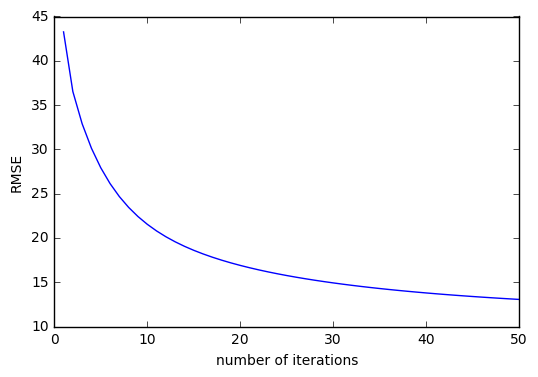

In [5]:
#load the test data
validationDatas = []
readData('validationOut1w.json', validationDatas)
print("the number of users in test data is:" + str(len(testDatas)) + "\n")

gama = 0.02
lamda = 0.25
slowRate = 0.99
step = 0
preRmse = 1000000000.0 
nowRmse = 0.0
step_l = list()
rmse_SGD = list()
while step < 50:    
		rmse = 0.0    
		n = 0
		count = 0.
		for review in validationDatas:
			userID = review['userID']
			for rating in review['ratings']:
				itemID = rating['itemID']
				realRating = float(rating['rating'])
				pui = 0.
				eui = 0.
				count += 1
				if rating['number'] in userSessionBiases[userID]:
					if itemID in itemBiases:
						#count += 1
						if itemID in trackBiases:
							pui = 1.0 * (aveRate + userTaxBiases[userID]['track'] + trackTaxBiases[itemID] + userSessionBiases[userID][rating['number']])
							eui = realRating - pui         
							userTaxBiases[userID]['track'] += gama * (eui - lamda * userTaxBiases[userID]['track'])    
							trackTaxBiases[itemID] += gama * (eui - lamda * trackTaxBiases[itemID])
						elif itemID in albumBiases:
							pui = 1.0 * (aveRate + userTaxBiases[userID]['album'] + albumTaxBiases[itemID] + userSessionBiases[userID][rating['number']])       
							eui = realRating - pui         
							userTaxBiases[userID]['album'] += gama * (eui - lamda * userTaxBiases[userID]['album'])    
							albumTaxBiases[itemID] += gama * (eui - lamda * albumTaxBiases[itemID])
						else:
							if itemID in artistBiases:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['artist'] + itemBiases[itemID] + userSessionBiases[userID][rating['number']])       
								eui = realRating - pui          
								userTaxBiases[userID]['artist'] += gama * (eui - lamda * userTaxBiases[userID]['artist'])    
							elif itemID in genreBiases:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['genre'] + itemBiases[itemID] + userSessionBiases[userID][rating['number']])       
								eui = realRating - pui      
								userTaxBiases[userID]['genre'] += gama * (eui - lamda * userTaxBiases[userID]['genre'])    
							itemBiases[itemID] += gama * (eui - lamda * itemBiases[itemID])
					#if the current item does not exist in train data, the bias is zero
					else:
						if itemID in trackList:
							pui = 1.0 * (aveRate + userTaxBiases[userID]['track'] + userSessionBiases[userID][rating['number']])       
							eui = realRating - pui         
							userTaxBiases[userID]['track'] += gama * (eui - lamda * userTaxBiases[userID]['track'])
						elif itemID in albumList:
							pui = 1.0 * (aveRate + userTaxBiases[userID]['album'] + userSessionBiases[userID][rating['number']])       
							eui = realRating - pui         
							userTaxBiases[userID]['album'] += gama * (eui - lamda * userTaxBiases[userID]['album'])
						elif  itemID in artistList:
							pui = 1.0 * (aveRate + userTaxBiases[userID]['artist'] + userSessionBiases[userID][rating['number']])       
							eui = realRating - pui          
							userTaxBiases[userID]['artist'] += gama * (eui - lamda * userTaxBiases[userID]['artist'])
						elif itemID in genreList:
							pui = 1.0 * (aveRate + userTaxBiases[userID]['genre'] + userSessionBiases[userID][rating['number']])       
							eui = realRating - pui       
							userTaxBiases[userID]['genre'] += gama * (eui - lamda * userTaxBiases[userID]['genre'])
					userSessionBiases[userID][rating['number']] += gama * (eui - lamda * userSessionBiases[userID][rating['number']])
				else:
					if itemID in itemBiases:
							if itemID in trackBiases:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['track'] + trackTaxBiases[itemID])
								eui = realRating - pui      
								userTaxBiases[userID]['track'] += gama * (eui - lamda * userTaxBiases[userID]['track'])    
								trackTaxBiases[itemID] += gama * (eui - lamda * trackTaxBiases[itemID])
							elif itemID in albumBiases:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['album'] + albumTaxBiases[itemID])       
								eui = realRating - pui          
								userTaxBiases[userID]['album'] += gama * (eui - lamda * userTaxBiases[userID]['album'])    
								albumTaxBiases[itemID] += gama * (eui - lamda * albumTaxBiases[itemID])
							else:
								if itemID in artistBiases:
									pui = 1.0 * (aveRate + userTaxBiases[userID]['artist'] + itemBiases[itemID])       
									eui = realRating - pui          
									userTaxBiases[userID]['artist'] += gama * (eui - lamda * userTaxBiases[userID]['artist'])    
								elif itemID in genreBiases:
									pui = 1.0 * (aveRate + userTaxBiases[userID]['genre'] + itemBiases[itemID])       
									eui = realRating - pui        
									userTaxBiases[userID]['genre'] += gama * (eui - lamda * userTaxBiases[userID]['genre'])    
								itemBiases[itemID] += gama * (eui - lamda * itemBiases[itemID])
						#if the current item does not exist in train data, the bias is zero
					else:
							if itemID in trackList:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['track'])       
								eui = realRating - pui          
								userTaxBiases[userID]['track'] += gama * (eui - lamda * userTaxBiases[userID]['track'])
							elif itemID in albumList:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['album'])       
								eui = realRating - pui        
								userTaxBiases[userID]['album'] += gama * (eui - lamda * userTaxBiases[userID]['album'])
							elif  itemID in artistList:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['artist'])       
								eui = realRating - pui       
								userTaxBiases[userID]['artist'] += gama * (eui - lamda * userTaxBiases[userID]['artist'])
							elif itemID in genreList:
								pui = 1.0 * (aveRate + userTaxBiases[userID]['genre'])       
								eui = realRating - pui      
								userTaxBiases[userID]['genre'] += gama * (eui - lamda * userTaxBiases[userID]['genre'])
				rmse += pow(eui,2)  
		nowRmse = sqrt(rmse*1.0/count)
		#print('step: %d      Rmse: %s' % ((step+1), nowRmse))
		if (nowRmse < preRmse):    
			preRmse = nowRmse    
		gama *= slowRate    
		step += 1
		step_l.append(step)
		rmse_SGD.append(nowRmse)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(step_l, rmse_SGD)
plt.xlabel('number of iterations')
plt.ylabel('RMSE')

#check the RMSE with addtion of user session bias
# predRatings = []
# realRatings = []
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['track']
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['album']
            else:
                if itemID in artistBiases:
                    curUserBias = userTaxBiases[userID]['artist']
                elif itemID in genreBiases:
                    curUserBias = userTaxBiases[userID]['genre']
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        #check if user has session bias
        if rating['number'] in userSessionBiases[userID]:
            curUserBias += userSessionBiases[userID][rating['number']]
        
        
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2 
#         predRatings.append(aveRate + curItemBias + curUserBias)
#         realRatings.append(realRating)
        errors.append(aveRate + curItemBias + curUserBias - realRating)
#         squareSum += (aveRate + userBiases[userID] + curItemBias + curUserBias - realRating) ** 2
          
RMSE4_SGD = sqrt(squareSum / float(count))
print('the full taxonomy model with user session bias RMSE after SGD is: ' + str(RMSE4_SGD))
print('the number of views in test data is: ' + str(count))

**4.6 Model with Partial trainning **
--

After observing some data from training set, we find that lots of items had been rated zero score. And then we observe surprisingly that lots of zero point were rated by the same people at the same time, then we are very curious about that since no one have this ability to rate so many items at same time except robot! These zero socres are useless for model training so that we try to eliminate all zero score from training set and calculate average of other part, we find the average increase by around 20! That is a huge number, which means the number of zero score is also very huge. That is strange, since according to normal score distribution, zero score cannot take up so much, which confirmed most zero score is fake. So, for our zero model, we decide to eliminate zero point from train set and use spare data to train a new model. The new model’s RMSE is higher than the model trained by training set with 0 score. 

In [6]:
import json
from math import sqrt

def readData(filename, list):
	with open(filename, 'r') as f:
		for line in f:
			list.append(json.loads(line))

#load the trainning data
trainDatas = []
readData('trainOutNoZero.json', trainDatas)
print("the number of users in trainning data is:" + str(len(trainDatas)) + "\n")

#construct the dict by itemID
trainReviews = {}#improve the speed of finding
for review in trainDatas:
    for rating in review["ratings"]:
        itemID = rating["itemID"]
        if itemID in trainReviews:
            trainReviews[itemID].append(rating)
        else:
            trainReviews[itemID] = [rating]
print('the number of distinct items is: ' + str(len(trainReviews)))

#the average of all rating
aveRate = 0
count = 0
for review in trainDatas:
    for rating in review["ratings"]:
        aveRate += int(rating["rating"])
        count += 1
aveRate /= float(count)
print('the overall average rating is: ' + str(aveRate))

def itemBias(itemID, aveRating):

    #    use the trainReviews(dict) which is sorted by itemId

    numRating = 0
    sumRating = 0
    if itemID in trainReviews:
        for rating in trainReviews[itemID]:
            numRating += 1
            sumRating += float(rating['rating'])
    else:#if there is no such itemID's rating the itemBias is zero
        return 0
    return sumRating / float(numRating) - aveRating

def userBias(userID, aveRating):

    #    use the trainOut format to find the userBias

    numRating = 0
    sumRating = 0
    for review in trainDatas:
        if review['userID'] == userID:
            for rating in review["ratings"]:
                numRating += 1
                sumRating += float(rating['rating'])
            break#if get the user info then stop the loop
    if numRating == 0:
        return 0
    return sumRating / float(numRating) - aveRating

#get the user bias matrix from train data
userBiases = {}
for review in trainDatas:
	userID = review['userID']
	userBiases[userID] = userBias(userID, aveRate)

#get the item bias matrix from train data
itemBiases = {}
for itemID in trainReviews:
    itemBiases[itemID] = itemBias(itemID, aveRate)
    
##
#  extract the items biases with different types from the partial trainData
##
#extract the track bias
trackBiases = {}
for itemID in trackList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		trackBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		trackBiases[itemID] = 0
print('the size of trackBiases is: ' + str(len(trackBiases)))

#extract the album bias
albumBiases = {}
for itemID in albumList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		albumBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		albumBiases[itemID] = 0
print('the size of albumBiases is: ' + str(len(albumBiases)))

#extract the artist bias
artistBiases = {}
for itemID in artistList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		artistBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		artistBiases[itemID] = 0
print('the size of artistBiases is: ' + str(len(artistBiases)))

#extract the genre bias
genreBiases = {}
for itemID in genreList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		genreBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		genreBiases[itemID] = 0
print('the size of genreBiases is: ' + str(len(genreBiases)))

#read the tracks
trackDatas = []
readData('data_preprocess/trackOut.json', trackDatas)
print('the size of track is: ' + str(len(trackDatas)))

#construct the dict by trackID
trackDict = {}
for track in trackDatas:
    trackDict[track['trackID']] = track
print('the number of tracks is: ' + str(len(trackDict)))

#expand the track bias
def getTaxTrackBias(itemID):
    if itemID in trackBiases:#should check this, since not all track in this partial train data
        bi = trackBiases[itemID]
    else:
        return 0
    
    genreRateSum = 0
    genreNum = 0
    biGenre = 0
    biAlbum = 0
    biArtist = 0
    
    track = trackDict[itemID]
    if track["albumID"] in albumBiases:
        #assume that the track only belong to exactly one album
        biAlbum = albumBiases[track["albumID"]]
            
    if track['artistID'] in artistBiases:
        #assume that the track only belong to exactly one artist
        biArtist = artistBiases[track["artistID"]]
            
    for genreID in track['genreList']:
        if genreID in genreBiases:
            genreRateSum += genreBiases[genreID]
            genreNum += 1
        if genreNum != 0:
            biGenre = float(genreRateSum) / float(genreNum)
        
    taxTrackBias = bi + biAlbum + biArtist + biGenre

    return taxTrackBias

#pre-build the trackTaxBiases
trackTaxBiases = {}
for itemID in trainReviews:
    if itemID in trackBiases:
        trackTaxBiases[itemID] = getTaxTrackBias(itemID)
print('the size of track tax biases is: ' + str(len(trackTaxBiases)))
# print(trackTaxBiases['0'])

#read the albums 
albumDatas = []
readData('data_preprocess/albumOut.json', albumDatas)
print('the size of album is: ' + str(len(albumDatas)))

#construct the dict by albumID
albumDict = {}
for album in albumDatas:
    albumDict[album['albumID']] = album
print('the number of albums is: ' + str(len(albumDict)))

#expand the album bias
def getTaxAlbumBias(itemID):
    if itemID in albumBiases:#should check this, since not all album in this partial data
		bi = albumBiases[itemID]
    else:
		return 0
    
    genreRateSum = 0
    genreNum = 0
    biGenre = 0
    biArtist = 0
    
    album = albumDict[itemID]
    if album['artistID'] in artistBiases:
        #assume that the album only belong to exactly one artist
        biArtist = artistBiases[album["artistID"]]
            
    for genreID in album['genreList']:
        if genreID in genreBiases:
            genreRateSum += genreBiases[genreID]
            genreNum += 1
        if genreNum != 0:
            biGenre = float(genreRateSum) / float(genreNum)
    
    taxAlbumBias = bi + biArtist + biGenre
    return taxAlbumBias

#pre-build the albumTaxBiases
albumTaxBiases = {}
for itemID in trainReviews:
    if itemID in albumBiases:
        albumTaxBiases[itemID] = getTaxAlbumBias(itemID)
print('the size of album tax biases is: ' + str(len(albumTaxBiases)))

def userTaxBias(userID):
    bu = userBiases[userID]
    userTaxBiases = {'track':0,'album':0,'artist':0,'genre':0}
    numTrackRate = 0
    numAlbumRate = 0
    numArtistRate = 0
    numGenreRate = 0
    
    sumTrackRate = 0
    sumAlbumRate = 0
    sumArtistRate = 0
    sumGenreRate = 0

#     review = trainDatas[int(userID) - 30000]#since the ID of users is continuous
    for curReview in trainDatas:
        if curReview['userID'] == userID:
            review = curReview#since the ID of users is continuous
            break
    
    for rating in review['ratings']:
        itemID = rating['itemID']
        score = float(rating['rating'])
        if itemID in trackBiases:
            sumTrackRate += score
            numTrackRate += 1
        elif itemID in albumBiases:
            sumAlbumRate += score
            numAlbumRate += 1
        elif itemID in artistBiases:
            sumArtistRate += score
            numArtistRate += 1
        elif itemID in genreBiases:
            sumGenreRate += score
            numGenreRate += 1
    if numTrackRate != 0:
        userTaxBiases['track'] = sumTrackRate / float(numTrackRate) - aveRate
    if numAlbumRate != 0:   
        userTaxBiases['album'] = sumAlbumRate / float(numAlbumRate) - aveRate
    if numArtistRate != 0:
        userTaxBiases['artist'] = sumArtistRate / float(numArtistRate) - aveRate
    if numGenreRate != 0:
        userTaxBiases['genre'] = sumGenreRate / float(numGenreRate) - aveRate
    
    return userTaxBiases

#pre-build the tax user biases
userTaxBiases = {}
for review in trainDatas:
    userID = review['userID']
    userTaxBiases[userID] = userTaxBias(userID)
print('the number of users in train data is: ' + str(len(userTaxBiases)))
# print(userTaxBiases['0'])

def getUserSessionBias(ratings):
    userSessionBias = {}
    count = {}
    for rating in ratings:
        number = rating['number']
        if number in userSessionBias:
            userSessionBias[number] += float(rating['rating'])
            count[number] += 1
        else:
            userSessionBias[number] = float(rating['rating'])
            count[number] = 1
    for number in userSessionBias.keys():
        userSessionBias[number] = userSessionBias[number] / float(count[number]) - aveRate
    return userSessionBias

#get the user's session biases 
userSessionBiases = {}
for review in trainDatas:
    userID = review['userID']
    userSessionBiases[userID] = getUserSessionBias(review['ratings'])
    
#check the RMSE with addtion of user session bias
predRatings = []
realRatings = []
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    if userID not in userBiases:
        continue
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['track']
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['album']
            else:
                if itemID in artistBiases:
                    curUserBias = userTaxBiases[userID]['artist']
                elif itemID in genreBiases:
                    curUserBias = userTaxBiases[userID]['genre']
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        #check if user has session bias
        if rating['number'] in userSessionBiases[userID]:
            curUserBias += userSessionBiases[userID][rating['number']]
        
        
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2 
        predRatings.append(aveRate + curItemBias + curUserBias)
        realRatings.append(realRating)
        errors.append(aveRate + curItemBias + curUserBias - realRating)
#         squareSum += (aveRate + userBiases[userID] + curItemBias + curUserBias - realRating) ** 2

            
RMSE5 = sqrt(squareSum / float(count))
print('the full taxonomy model with user session bias without zero training ratings RMSE is: ' + str(RMSE5))
print('the number of views in test data is: ' + str(count))

the number of users in trainning data is:9998

the number of distinct items is: 295455
the overall average rating is: 71.2783178904
the size of trackBiases is: 507172
the size of albumBiases is: 88909
the size of artistBiases is: 27888
the size of genreBiases is: 992
the size of track is: 507172
the number of tracks is: 507172
the size of track tax biases is: 225515
the size of album is: 88909
the number of albums is: 88909
the size of album tax biases is: 53033
the number of users in train data is: 9998
the full taxonomy model with user session bias without zero training ratings RMSE is: 37.9934142785
the number of views in test data is: 59988


5. Evaluation
==

We will learn the model on the training dataset using a stochastic gradient descent algorithm. And we then tested the results in terms of RMSE.

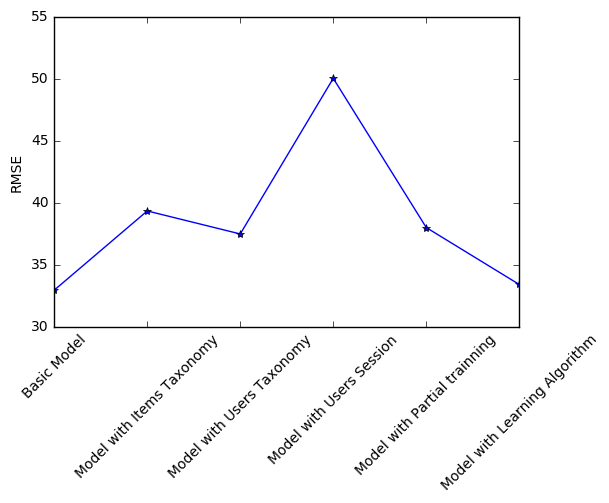

In [7]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array([1,2,3,4,5,6])
y1 = np.array([RMSE1,RMSE2,RMSE3,RMSE4,RMSE5,RMSE4_SGD])
my_xticks = ['Basic Model','Model with Items Taxonomy','Model with Users Taxonomy','Model with Users Session','Model with Partial trainning','Model with Learning Algorithm']
plt.xticks(x, my_xticks,rotation=45)
plt.plot(x, y1, marker='*')
plt.ylabel('RMSE')
plt.show()

# 6.Conclusion and Next Steps

At the beginning of this project, the raw dataset is extremely huge, we learned how to do data preprocess and using program to convert the raw .txt data files into JSON file with the useful data structure which is convenient for using in later part of our project. In the hands-on experience of doing this project, we found that even though the algorithm which we have learned in class at detail, we should take time complexity and space complexity of program into account.

In the processing of implementing the model which the paper presents, we cannot get the expected result. We begin to find the reason and drawbacks of the model and to do optimization by adding the new component. 

We use bias model of recommander as the basic frame in our project, then promote the basic bias model with hierachical relationship between tracks, albums, artists and genres.  
 Also we implement stochastic gradient descent(SGD) to optimize our final model and yield a better result compare to the RMSE without optimization.

We can continually improve our model by adding, and then promote the a classical matrix factorization approach by adding taxonomy vector into original MF model.  